# Modelling and Extraction

In [ ]:
import json
import os

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pickle

# Modelling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XAI
import shap
from lime.lime_tabular import LimeTabularExplainer


In [4]:
WYSCOUT_DATA_FOLDER = "../wyscout_figshare_data" 

df = pd.read_csv("../final_processed_data.csv")

with open(os.path.join(WYSCOUT_DATA_FOLDER, 'teams.json')) as f:
    teams_meta = json.load(f)
team_names_dict = {t['wyId']:t['name'] for t in teams_meta}

p = df.groupby(["matchId", "teamId", "minutes_remaining"]).agg(
    score_differential =("score_differential", "last"), 
    goals_scored = ("goals_scored", "last"), 
    player_differential = ("player_differential", "last"), 
    own_yellow_cards = ("own_yellow_cards", "last"), 
    opposition_yellow_cards = ("opposition_yellow_cards", "last"), 
    is_home_team = ("is_home_team", "last"), 
    avg_team_xt = ("avg_team_xt", "last"), 
    avg_opp_xt = ("avg_opp_xt", "last"), 
    running_xt_differential = ("running_xt_differential", "mean"), 
    scored_goal_after = ("scored_goal_after", "last"), 
    time_interval=('time_interval', 'last')
).reset_index().sort_values(['matchId', 'time_interval'])

print(df.shape)
print(p.shape)

(556752, 38)
(61397, 14)


I have not used any AI assistance in cell above.

In [5]:
# Getting match id for the specific games
chelsea_match = p[p['teamId'] == 1609]['matchId'].to_list()
burnley_match = p[p['teamId'] == 1624]['matchId'].to_list()


common_matches = set(chelsea_match).intersection(set(burnley_match))
common_matches

{2499830, 2499987}

In [6]:
df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,goals_scored,player_differential,own_yellow_cards,opposition_yellow_cards,is_home_team,avg_team_xt,avg_opp_xt,home_num_goals_scored_after,away_num_goals_scored_after,scored_goal_after
0,8,Simple pass,[{'id': 1801}],10252,"[{'y': 51, 'x': 50}, {'y': 40, 'x': 31}]",2500048,Pass,10531,1H,3.050446,...,0,0,0,0,0,1.059127,1.430297,1,1,0.010101
1,8,Simple pass,[{'id': 1801}],246866,"[{'y': 40, 'x': 31}, {'y': 88, 'x': 29}]",2500048,Pass,10531,1H,3.468107,...,0,0,0,0,0,1.059127,1.430297,1,1,0.010101
2,8,High pass,[{'id': 1802}],284,"[{'y': 88, 'x': 29}, {'y': 42, 'x': 69}]",2500048,Pass,10531,1H,8.349323,...,0,0,0,0,0,1.059127,1.430297,1,1,0.010101
3,8,Head pass,[{'id': 1801}],5281,"[{'y': 58, 'x': 31}, {'y': 20, 'x': 42}]",2500048,Pass,1627,1H,10.104679,...,0,0,0,0,1,1.430297,1.059127,1,1,0.010101
4,8,Head pass,[{'id': 1802}],8370,"[{'y': 20, 'x': 42}, {'y': 44, 'x': 72}]",2500048,Pass,1627,1H,11.599694,...,0,0,0,0,1,1.430297,1.059127,1,1,0.010101


In [7]:
p.sample(100)

,matchId,teamId,minutes_remaining,score_differential,goals_scored,player_differential,own_yellow_cards,opposition_yellow_cards,is_home_team,avg_team_xt,avg_opp_xt,running_xt_differential,scored_goal_after,time_interval
43072,2499984,1619,13,-2,0,0,1,2,1,2.334171,2.040163,0.010059,0.000000,87
33416,2499927,10531,55,-1,0,0,2,1,0,1.136777,1.846263,0.000968,0.035088,43
40363,2499969,1639,5,-1,1,0,3,2,0,1.428956,1.359267,0.001326,0.000000,95
46228,2500004,1610,83,0,0,0,0,0,0,2.006777,2.599578,0.022219,0.000000,12
15102,2499812,1646,67,0,0,0,0,0,1,1.730621,0.829199,0.000319,0.014085,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53841,2500047,1644,79,0,0,0,0,0,1,1.735830,1.844248,-0.000877,0.012346,19
59530,2500084,1633,75,0,0,0,0,0,0,1.427280,1.375895,0.002374,0.025641,22
46649,2500006,10531,39,3,3,0,0,1,1,1.266358,1.504457,0.009764,0.000000,63
15468,2499814,1631,61,2,2,0,0,1,1,1.197289,1.439682,0.004814,0.000000,36


In [8]:
# Matches to test
holdout_match_ids = [2499737, 2500031, 2499754, 2499943, 2499830] 


Following match id excluded from the development process and used in the simulation process only.

In [9]:
cols =  [
    'goals_scored',
    'player_differential', 
    'own_yellow_cards', 
    'opposition_yellow_cards', 
    'is_home_team',
    'avg_team_xt', 
    'avg_opp_xt', 
    'time_interval', 
    'running_xt_differential',
    'score_differential'
]

features = [
    'goals_scored',
    'player_differential', 
    'own_yellow_cards', 
    'opposition_yellow_cards', 
    'is_home_team',
    'avg_team_xt', 
    'avg_opp_xt', 
    'running_xt_differential',
    'score_differential'
]

target = 'scored_goal_after'

X_train, X_test, y_train, y_test = train_test_split(p.query("matchId != @holdout_match_ids")[cols], 
                                                    p.query("matchId != @holdout_match_ids")[target], 
                                                    test_size=0.2, random_state=42
                                                   )

I have not used any AI assistance in cell above.

Feature selection and data split

In [43]:
model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=500,
    learning_rate=0.1,
)

X_train_reg = X_train[features].fillna(0)
X_test_reg  = X_test[features].fillna(0)

model.fit(
    X_train_reg,
    y_train,
    eval_set=[(X_test_reg, y_test)],
    eval_metric="rmse",
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 48366, number of used features: 9
[LightGBM] [Info] Start training from score 0.012700


LGBMRegressor(n_estimators=500, random_state=42)

I have not used any AI assistance in cell above.

In [44]:

y_pred = model.predict(X_test_reg)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Accuracy Metrics")
print("------------------------")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

Model Accuracy Metrics
------------------------
MAE : 0.0051
MSE : 0.0002
RMSE: 0.0157
R²  : 0.6389


LightGBM Model Training

In [52]:
# Save model
with open("../models/lightgbm/football.pkl", "wb") as f:
    pickle.dump(model, f)

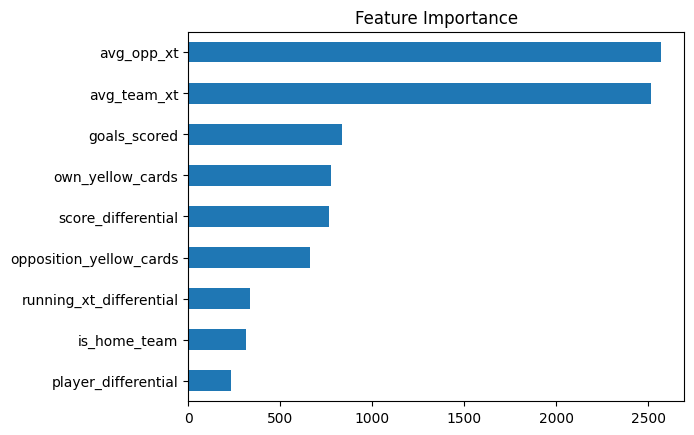

In [13]:
(pd.Series(model.feature_importances_, index=features)
 .sort_values()
   .plot(kind='barh', title='Feature Importance'));

The most important features seem to be the pre-match team strength indicators - `avg_team_xt` & `avg_opp_xt` - which does make sense. Remember, at this point we are not trying to predict the win probability but simply the probability of the teams scoring in the remaining time intervals. Using the model predicted probabilities to simulate and calculate the win probability comes next. 

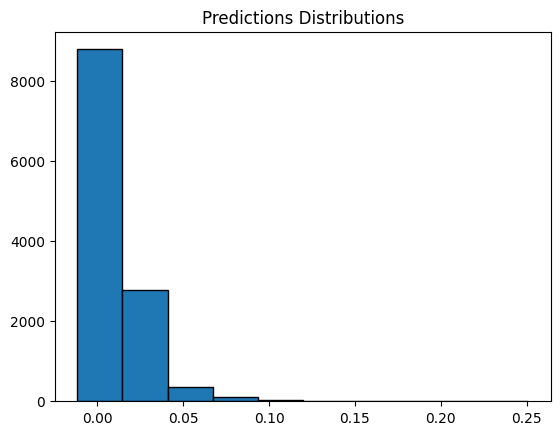

In [14]:
plt.hist(model.predict(X_test[features]), ec='k') 
plt.title('Predictions Distributions');

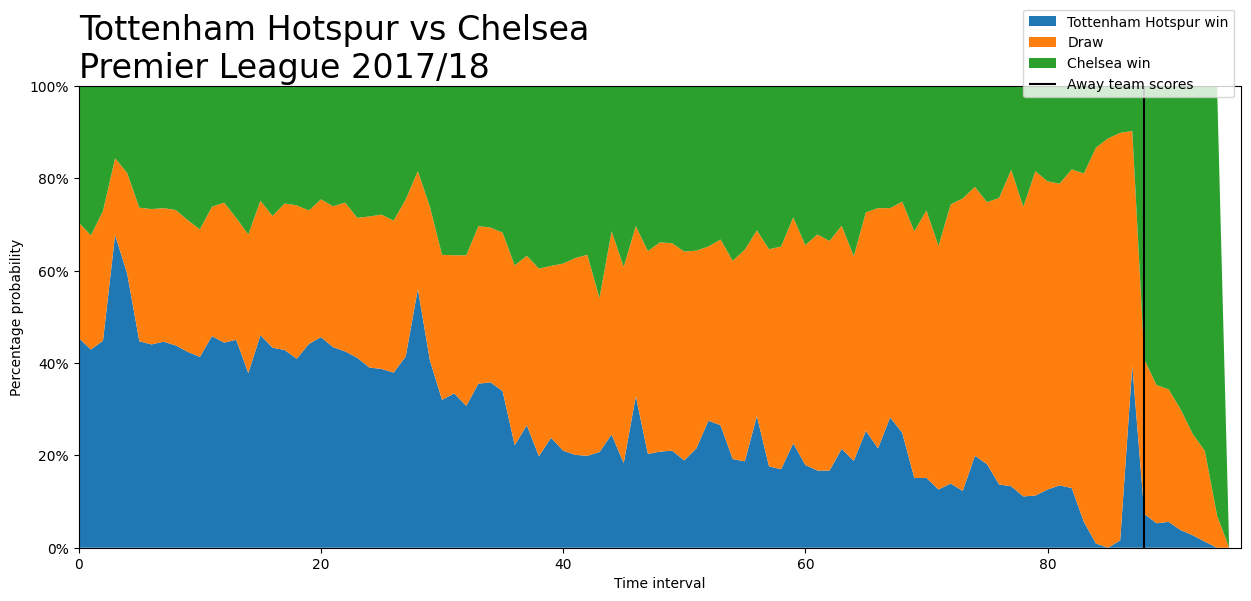

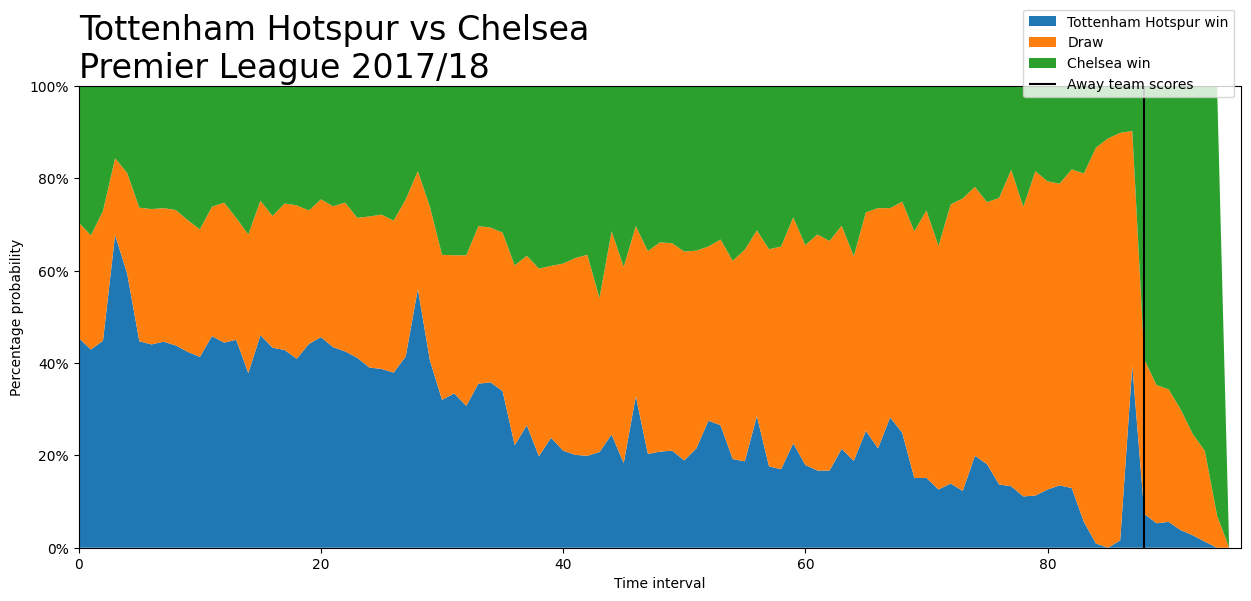

In [47]:
n_sims = 1000  # number of simulations for each remaining time interval
fig, axes = plt.subplots(figsize=(15, 6), sharey=True)

for holdout_match_id, ax in zip(holdout_match_ids, [axes]):
    # 1. Filter to that match
    holdout = p.query("matchId == @holdout_match_id").copy()

    # 2. Predict with regressor and convert to valid probabilities
    X_holdout = holdout[features].fillna(0)
    raw_pred = model.predict(X_holdout)

    # Clip raw regression output into [0,1]
    holdout["team_scoring_prob"] = np.clip(raw_pred, 0.0, 1.0)

    # 3. Get home / away IDs
    home_team_id = holdout.query("is_home_team == 1").teamId.unique()[0]
    away_team_id = holdout.query("is_home_team == 0").teamId.unique()[0]

    # 4. Pivot to per-minute, per-team structure
    h = holdout.pivot_table(
        index="time_interval",
        columns="teamId",
        values=["team_scoring_prob", "score_differential"],
    ).reset_index()

    h.columns = [a + "_" + str(b) for (a, b) in h.columns]
    h = h.reset_index(drop=True)

    # 5. Fix missing score_differential rows (mirror from other team)
    for idx in h[h.isnull().any(axis=1)].index:
        if h.loc[idx, f"score_differential_{home_team_id}"] != h.loc[idx, f"score_differential_{home_team_id}"]:
            h.loc[idx, f"score_differential_{home_team_id}"] = -h.loc[idx, f"score_differential_{away_team_id}"]
        elif h.loc[idx, f"score_differential_{away_team_id}"] != h.loc[idx, f"score_differential_{away_team_id}"]:
            h.loc[idx, f"score_differential_{away_team_id}"] = -h.loc[idx, f"score_differential_{home_team_id}"]

    h = h.fillna(0)

    # 6. Run simulations
    home_wins_list = []
    away_wins_list = []
    draws_list = []

    for time_interval, hsd, asd, h_prob, a_prob in zip(
        h["time_interval_"],
        h[f"score_differential_{home_team_id}"],
        h[f"score_differential_{away_team_id}"],
        h[f"team_scoring_prob_{home_team_id}"],
        h[f"team_scoring_prob_{away_team_id}"],
    ):
        if time_interval != 100:
            remaining = int(100 - time_interval)

            # Extra safety: ensure probs are in [0,1] and not NaN
            h_prob = float(np.clip(h_prob, 0.0, 1.0))
            a_prob = float(np.clip(a_prob, 0.0, 1.0))

            if np.isnan(h_prob):
                h_prob = 0.0
            if np.isnan(a_prob):
                a_prob = 0.0

            home_goals_sim = np.random.binomial(remaining, h_prob, n_sims)
            away_goals_sim = np.random.binomial(remaining, a_prob, n_sims)

            home_sd_sim = hsd + (home_goals_sim - away_goals_sim)

            home_wins = np.sum(home_sd_sim > 0)
            away_wins = np.sum(home_sd_sim < 0)
            draws = np.sum(home_sd_sim == 0)

            home_wins_list.append((home_wins / n_sims) * 100)
            away_wins_list.append((away_wins / n_sims) * 100)
            draws_list.append((draws / n_sims) * 100)
        else:
            home_wins_list.append(0)
            away_wins_list.append(0)
            draws_list.append(0)

    # 7. Stackplot
    y = np.vstack([home_wins_list, draws_list, away_wins_list])

    ax.stackplot(
        range(len(home_wins_list)),
        y,
        labels=[
            f"{team_names_dict[home_team_id]} win",
            "Draw",
            f"{team_names_dict[away_team_id]} win",
        ],
    )
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    # 8. Goal event markers
    draw_home_goals = draw_away_goals = True
    score_diff_series = h[f"score_differential_{home_team_id}"]
    for (idx, val) in score_diff_series.diff().dropna().items():
        if val == 1:
            if draw_home_goals:
                draw_home_goals = False
                hlabel = "Home team scores"
            else:
                hlabel = None
            ax.vlines(idx, 0, 100, color=["white"], label=hlabel)
        elif val == -1:
            if draw_away_goals:
                alabel = "Away team scores"
                draw_away_goals = False
            else:
                alabel = None
            ax.vlines(idx, 0, 100, color=["black"], label=alabel)

    # 9. Cosmetics
    ax.set(
        xlabel="Time interval",
        ylabel="Percentage probability",
        xlim=(0, len(home_wins_list)),
        ylim=(0, 100),
    )

    ax.title.set(
        text=f"{team_names_dict[home_team_id]} vs {team_names_dict[away_team_id]}\nPremier League 2017/18",
        fontsize=24,
        x=0,
        ha="left",
    )

    ax.legend(loc=1, bbox_to_anchor=(0.8, 0.98, 0.2, 0.2))

fig

Citation : The above code snippet was generated using GPT 5 on 11/19/25 at 8:25p. 

Graph representation of the model simulation process.

## SHAP analysis

In [16]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[features])  
expected_value = explainer.expected_value

In [17]:
len(shap_values)

12092

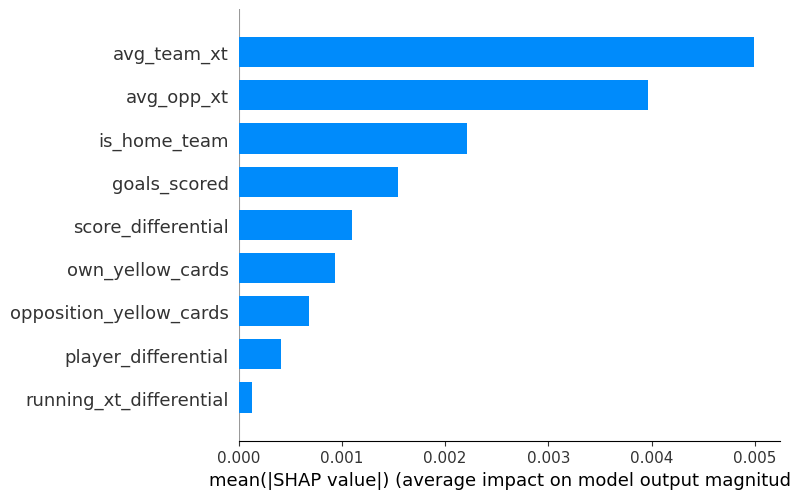

In [18]:
shap.summary_plot(shap_values, X_test[features], plot_type="bar")

In [19]:

np.save("../models/lightgbm/shap_values_test.npy", shap_values)
np.save("../models/lightgbm/shap_expected_value.npy", np.array([expected_value]))
np.save("../models/lightgbm/shap_feature_names.npy", np.array(features, dtype=object))

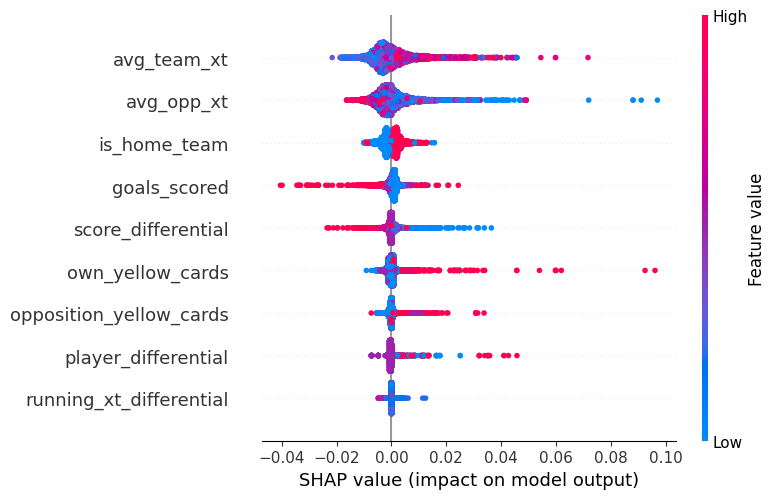

In [20]:
shap.summary_plot(shap_values, X_test[features], feature_names=features)

In [21]:
shap_cols = [f"shap_{f}" for f in features]

shap_df = pd.DataFrame(
    shap_values,
    index=X_test.index,      
    columns=shap_cols
)

## LIME

                            Feature  Contribution
0              is_home_team <= 0.00     -0.011527
1              goals_scored <= 0.00      0.006332
2   opposition_yellow_cards <= 0.00     -0.004171
3       score_differential <= -1.00      0.003722
4       player_differential <= 0.00      0.001935
5        1.59 < avg_team_xt <= 2.00      0.001911
6          own_yellow_cards <= 0.00     -0.001623
7                 avg_opp_xt > 2.00     -0.000149
8  running_xt_differential <= -0.00      0.000006
LIME Explanation for Sample: 0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


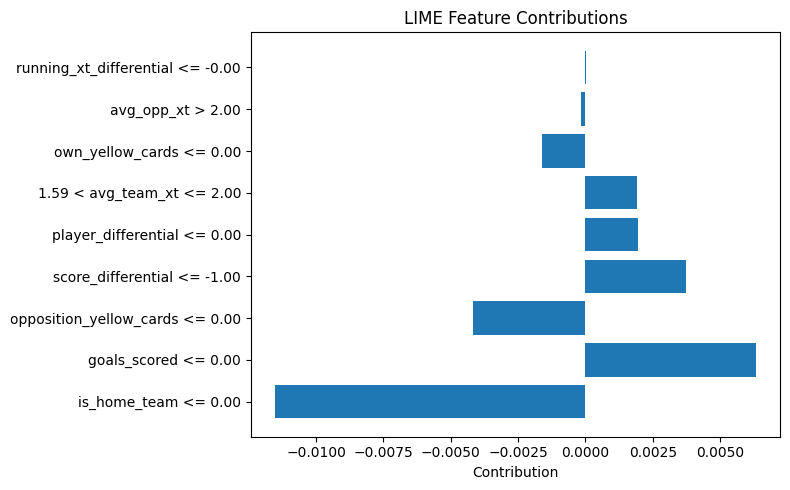

In [ ]:
X_train_lime = X_train[features].fillna(0).values
X_test_lime  = X_test[features].fillna(0).values

lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=features,
    mode="regression",
    verbose=False
)

i = 0
test_instance = X_test_lime[i]

lime_exp = lime_explainer.explain_instance(
    data_row=test_instance,
    predict_fn=model.predict,
    num_features=10  
)
lime_list = lime_exp.as_list()

lime_df = pd.DataFrame(lime_list, columns=["Feature", "Contribution"])
print(lime_df)

print("LIME Explanation for Sample:", i)
plt.figure(figsize=(8,5))
plt.barh(lime_df["Feature"], lime_df["Contribution"])
plt.xlabel("Contribution")
plt.title("LIME Feature Contributions")
plt.tight_layout()
plt.show()

Citation : The above code snippet was generated using GPT 5 on 11/22/25 at 6:25p. 

## Functionalizing the code

In [22]:
def plot_shap_for_holdout_state(
    match_id,
    team_id,
    time_interval,
    p,
    model,
    features,
    top_n=10
):
    """
    Plot a vertical SHAP barplot for a single row identified by
    (matchId, teamId, time_interval) in the holdout set.

    Parameters
    ----------
    match_id : int
    team_id : int
    time_interval : int
    p : pd.DataFrame
        Full processed dataframe containing matchId, teamId, time_interval, features, etc.
    model : fitted LightGBM (or tree-based) model
    features : list of str
        Feature column names used to train the model.
    top_n : int
        Number of top features (by |SHAP|) to display.
    """

    # 1. Find the row for this state
    mask = (
        (p["matchId"] == match_id) &
        (p["teamId"] == team_id) &
        (p["time_interval"] == time_interval)
    )

    if not mask.any():
        raise ValueError(
            f"No row found for matchId={match_id}, teamId={team_id}, "
            f"time_interval={time_interval}"
        )

    row = p.loc[mask].iloc[0]
    x_row = row[features].to_frame().T  # shape (1, n_features)

    # 2. Compute SHAP for this single row
    explainer = shap.TreeExplainer(model)
    shap_values_row = explainer.shap_values(x_row)[0]  # 1D array

    # 3. Sort features by absolute impact
    abs_shap = np.abs(shap_values_row)
    order = np.argsort(abs_shap)[::-1][:top_n]

    shap_top = shap_values_row[order]
    feats_top = [features[i] for i in order]
    vals_top = x_row.values[0][order]

    # 4. Vertical bar chart
    plt.figure(figsize=(10, 6))
    x_pos = np.arange(len(feats_top))
    colors = ["tab:red" if v < 0 else "tab:blue" for v in shap_top]

    plt.bar(x_pos, shap_top, color=colors)
    plt.xticks(x_pos, feats_top, rotation=90)
    plt.axhline(0, color="black", linewidth=0.8)

    # --- Symmetric y-axis around 0 with padding ---
    max_abs = np.max(np.abs(shap_top))
    ylim = 1.1 * max_abs  # 10% padding
    plt.ylim(-ylim, ylim)

    plt.title(
        f"SHAP values – Match {match_id}, Team {team_id}, Minute {time_interval}"
    )
    plt.ylabel("SHAP value (impact on prediction)")
    plt.tight_layout()
    plt.show()

    return {
        "features": feats_top,
        "shap_values": shap_top,
        "feature_values": vals_top,
        "row_index": row.name,
    }

Citation : The above code snippet was generated using GPT 5 on 11/20/25 at 1:21p. 

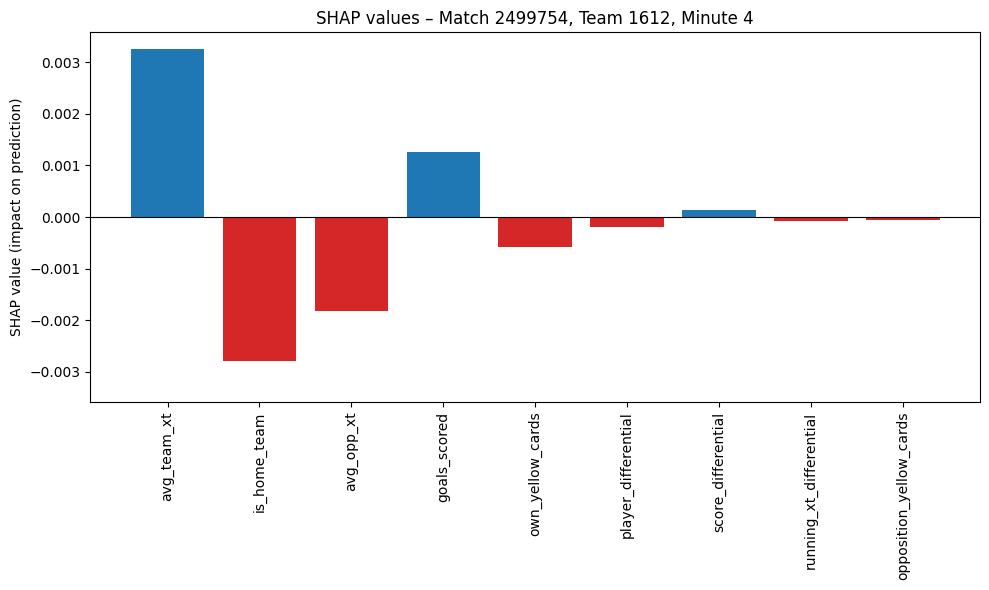

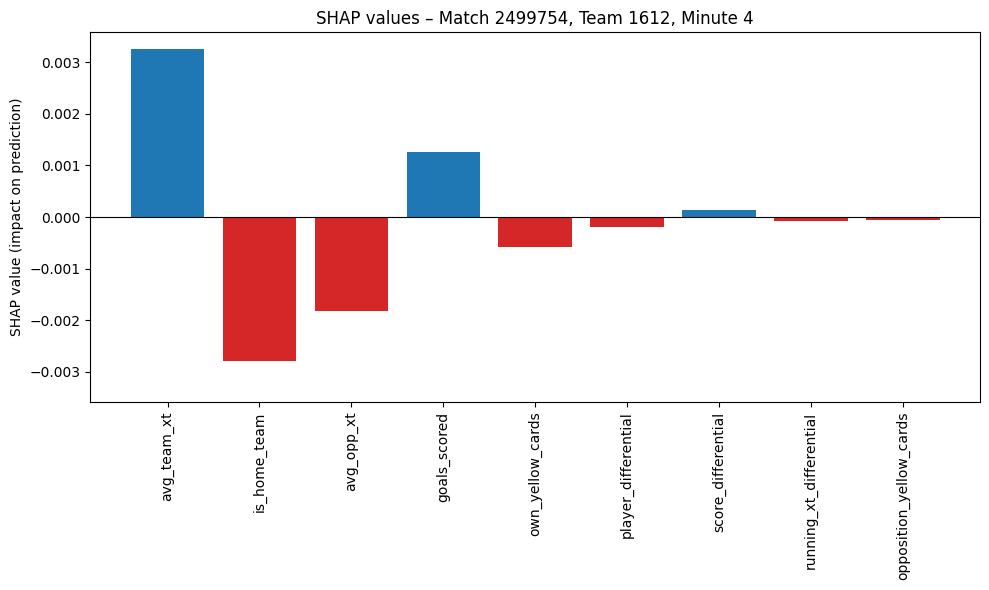

{'features': ['avg_team_xt',
  'is_home_team',
  'avg_opp_xt',
  'goals_scored',
  'own_yellow_cards',
  'player_differential',
  'score_differential',
  'running_xt_differential',
  'opposition_yellow_cards'],
 'shap_values': array([ 3.25565879e-03, -2.79962825e-03, -1.82588874e-03,  1.25536819e-03,
        -5.78258619e-04, -1.83156156e-04,  1.40970980e-04, -8.31543173e-05,
        -5.62943447e-05]),
 'feature_values': array([ 2.13114943e+00,  0.00000000e+00,  2.76879091e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.42106200e-04,
         0.00000000e+00]),
 'row_index': np.int64(5900)}

In [23]:

plot_shap_for_holdout_state(
    match_id=2499754,
    team_id=1612,       # replace with actual teamId in p
    time_interval=4,           # e.g., 60th minute
    p=p,
    model=model,
    features=features,
    top_n=10
)

plot_shap_for_holdout_state(
    match_id=2499754,
    team_id=1612,       # replace with actual teamId in p
    time_interval=4,           # e.g., 60th minute
    p=p,
    model=model,
    features=features,
    top_n=10
)

Looking at the local SHAP explanation for the given match and given minute. Later this will be the part of dashboard

Citation : The above code snippet was generated using GPT 5 on 11/20/25 at 1:22p. 

In [24]:

def get_match_probabilities(
    match_id: int,
    minute: int,
    p,
    model,
    features,
    n_sims: int = 50000,
):
    """
    Compute win/draw/win probabilities at a given state (match_id, minute).

    Uses the same logic as your simulation code:
    - predicts per-minute scoring probs for home & away
    - simulates the remaining minutes via binomial draws
    - returns probabilities from the *home-team perspective*.

    Assumes:
      - p has columns: ['matchId', 'teamId', 'is_home_team',
                        'time_interval', 'score_differential', ...features]
      - a global `team_names_dict` exists: {teamId: teamName}
    """

    # restrict to this match
    df = p[p["matchId"] == match_id].copy()
    if df.empty:
        raise ValueError(f"No data found for match_id={match_id}")

    # get home/away team IDs
    home_team_id = df.query("is_home_team == 1").teamId.unique()[0]
    away_team_id = df.query("is_home_team == 0").teamId.unique()[0]

    # optional: names from global dict (fallback to ID as string)
    home_team_name = team_names_dict.get(home_team_id, str(home_team_id))
    away_team_name = team_names_dict.get(away_team_id, str(away_team_id))

    # rows for this minute
    home_row = df[(df["is_home_team"] == 1) & (df["time_interval"] == minute)]
    away_row = df[(df["is_home_team"] == 0) & (df["time_interval"] == minute)]

    if home_row.empty or away_row.empty:
        raise ValueError(
            f"No data for match_id={match_id} at minute={minute} "
            f"(home_row.empty={home_row.empty}, away_row.empty={away_row.empty})"
        )

    home_row = home_row.iloc[0]
    away_row = away_row.iloc[0]

    # current score differential from *home* perspective
    hsd = home_row["score_differential"]

    # model's per-minute scoring probabilities
    h_prob = model.predict(home_row[features].values.reshape(1, -1))[0]
    a_prob = model.predict(away_row[features].values.reshape(1, -1))[0]

    remaining = 100 - minute  # same horizon as your original code

    # Monte Carlo simulation of remaining goals
    home_goals_sim = np.random.binomial(remaining, h_prob, n_sims)
    away_goals_sim = np.random.binomial(remaining, a_prob, n_sims)

    final_sd = hsd + (home_goals_sim - away_goals_sim)

    home_wins = np.mean(final_sd > 0)
    away_wins = np.mean(final_sd < 0)
    draws = np.mean(final_sd == 0)

    return {
        "match_id": match_id,
        "minute": minute,

        "home_team_id": home_team_id,
        "away_team_id": away_team_id,
        "home_team_name": home_team_name,
        "away_team_name": away_team_name,

        "home_win_prob": home_wins * 100,
        "draw_prob": draws * 100,
        "away_win_prob": away_wins * 100,
    }

Citation : The above code snippet was generated using GPT 5 on 11/20/25 at 4:45p. 

This function estimates win probabilities at a specific minute by combining the trained model with Monte-Carlo simulations. This is the core part of our modelling approach.
It filters the processed dataset `p` for the selected `match_id`, identifies the home/away teams, and loads their names. It then selects the two rows (home + away) corresponding to the exact `minute`, which contain all live features (score, cards, xT, etc.). If either row is missing, the function stops.
Using the trained model, it predicts:
- `h_prob`: probability the home team scores in a future minute  
- `a_prob`: probability the away team scores in a future minute  

It also computes the time left: `remaining = 100 - minute`.
It performs `n_sims` simulated versions of the rest of the match.  
For each simulation:
- Home future goals ~ Binomial(remaining, `h_prob`)  
- Away future goals ~ Binomial(remaining, `a_prob`)  
- Add these to the current score differential to get a final score outcome.
Across all simulations, it computes:
- % of simulations where home finishes ahead → **Home win %**  
- % tied → **Draw %**  
- % behind → **Away win %**


In [25]:
get_match_probabilities(
    match_id=2499754,
    minute=80,
    p=p,
    model=model,
    features=features
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'match_id': 2499754,
 'minute': 80,
 'home_team_id': np.int64(1625),
 'away_team_id': np.int64(1612),
 'home_team_name': 'Manchester City',
 'away_team_name': 'Liverpool',
 'home_win_prob': np.float64(99.628),
 'draw_prob': np.float64(0.332),
 'away_win_prob': np.float64(0.04)}

In [26]:
holdout = p.query("matchId in @holdout_match_ids").copy()
holdout.to_csv('../sample_games.csv')

Prepration of the choosen games for the dashboard.

In [27]:
holdout.sort_values(['matchId', 'time_interval'], ascending=False)

,matchId,teamId,minutes_remaining,score_differential,goals_scored,player_differential,own_yellow_cards,opposition_yellow_cards,is_home_team,avg_team_xt,avg_opp_xt,running_xt_differential,scored_goal_after,time_interval
50762,2500031,1610,0,-2,1,0,0,1,1,2.648665,1.936562,0.018599,0.000000,100
50856,2500031,1624,0,2,3,0,1,0,0,1.936562,2.648665,0.013949,0.000000,100
50763,2500031,1610,1,-2,1,0,0,1,1,2.648665,1.936562,0.015221,0.000000,99
50857,2500031,1624,1,2,3,0,1,0,0,1.936562,2.648665,0.012779,0.000000,99
50764,2500031,1610,2,-2,1,0,0,1,1,2.648665,1.936562,0.006902,0.000000,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,2499737,1624,95,0,0,0,0,0,1,1.998021,2.914339,-0.000250,0.000000,3
3099,2499737,1610,96,0,0,0,0,0,0,2.914339,1.998021,0.009999,0.010204,2
3195,2499737,1624,96,0,0,0,0,0,1,1.998021,2.914339,0.011480,0.000000,2
3100,2499737,1610,97,0,0,0,0,0,0,2.914339,1.998021,0.015642,0.010101,1


In [28]:
def build_match_table(holdout: pd.DataFrame, team_id_to_name: dict):
    """
    Create one row per match with home/away team IDs + names and final score.

    Assumes holdout has:
      - matchId
      - teamId
      - is_home_team (1=home, 0=away)
      - time_interval
      - goals_scored (cumulative goals for that team at that time)

    Returns:
      DataFrame with:
        match_id, home_team_id, home_team, away_team_id, away_team, home_score, away_score
    """

    df = holdout.copy()

    # 1) find final state rows per (match, team, side)
    idx_final = (
        df.sort_values("time_interval")
          .groupby(["matchId", "teamId", "is_home_team"], as_index=False)
          .tail(1)   # last row => biggest time_interval
          .index
    )
    final_rows = df.loc[idx_final].copy()

    # 2) split into home and away final rows
    home_final = final_rows[final_rows["is_home_team"] == 1].copy()
    away_final = final_rows[final_rows["is_home_team"] == 0].copy()

    # 3) keep only what we need and rename
    home_final = home_final[["matchId", "teamId", "goals_scored"]].rename(
        columns={"teamId": "home_team_id", "goals_scored": "home_score"}
    )
    away_final = away_final[["matchId", "teamId", "goals_scored"]].rename(
        columns={"teamId": "away_team_id", "goals_scored": "away_score"}
    )

    # 4) merge home + away into one row per match
    match_table = home_final.merge(away_final, on="matchId", how="inner")

    # 5) add names using your dict
    match_table["home_team"] = match_table["home_team_id"].map(team_id_to_name)
    match_table["away_team"] = match_table["away_team_id"].map(team_id_to_name)

    # 6) final formatting
    match_table = match_table.rename(columns={"matchId": "match_id"})
    match_table = match_table[
        ["match_id", "home_team_id", "home_team", "away_team_id", "away_team", "home_score", "away_score"]
    ].sort_values("match_id").reset_index(drop=True)

    return match_table

Citation : The above code snippet was generated using GPT 5 on 11/20/25 at 4:57p. 

In [29]:
match_table_summary = build_match_table(holdout, team_names_dict)
match_table_summary.head()

match_table_summary.to_csv('../match_summary.csv', index=False)